In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget
#plt.style.use('dark_background')
from vscode_dark_ipywidget_fix.inject_css import inject_css
inject_css()

import pickle

from icecream import ic
from scipy.linalg import eigh
from scipy.optimize import minimize


from grid_gaussians.gaussians import FourierGaussian1D
gaussians = FourierGaussian1D()

import numpy as np

from gauss1d import Gauss1D, LCGauss1D, plot_basis, plot_approx

gaussians = Gauss1D(verbose=False)
    


In [2]:
# choose type of state to make and associated parameters
name = 'fit'
n_gauss = 10
active = [0, 1, 2, 3]
p = 2.0



In [3]:


# Grid
grid_a = -150
grid_b = 150
grid_ng = 5001

# load sum of gaussians potential from pickle file 
fname = 'lcg_smoothed_coulomb_ngauss_20_p_1.pkl'
with open(fname, 'rb') as f:
    state = pickle.load(f)
    c_pot = state['c']
    z_pot = state['z']
    pot_name = state['name']
    n_pot = len(c_pot)
    E0_pot = state['E0']
    ic(E0_pot)
    ic(c_pot[::n_pot//2], z_pot[:1,:n_pot//2])




ic| E0_pot: -0.5000000200822465
ic| c_pot[::n_pot//2]: array([-0.05553248-22336.91676767j, -0.05553248+22336.91676767j])
    z_pot[:1,:n_pot//2]: array([[ 0.61493023, -0.62028669, -1.84235258, -3.10735059, -4.3622226 ,
                                 -5.71768557, -7.15736123, -8.7080419 , -9.03799213, -8.93329381]])


ic| E0: -0.5000000196490292


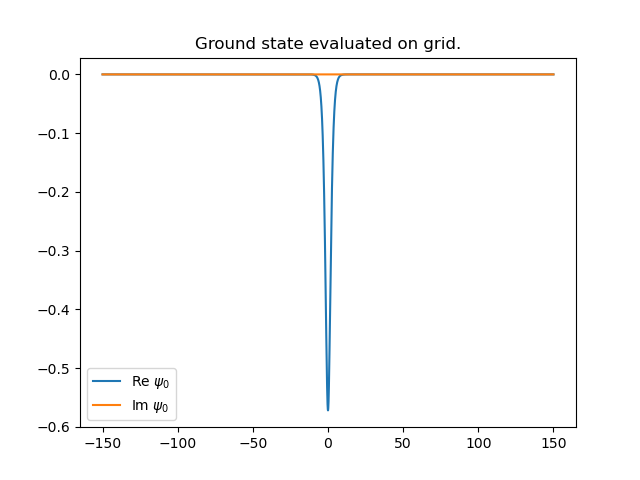

In [4]:
#
# diagonalize Hamiltoninan in a tempered basis of gaussians
#
n_diag = 30
a = np.linspace(-10,10,n_diag)
z_diag = np.zeros((4,n_diag))
z_diag[0,:] = a
lcgauss = LCGauss1D(gaussians)
lcgauss.set_z(z_diag)
lcgauss.set_potential(c_pot, z_pot)
lcgauss.overlap_matrix()
lcgauss.hamiltonian_matrix()
E, C = eigh(lcgauss.H, lcgauss.S)
E0 = E[0]
C0 = C[:,0]
ic(E0)

#
# Reconstruct a grid representation of the ground state
#
x = np.linspace(grid_a, grid_b, grid_ng)
psi0 = lcgauss.eval_grid(x, C0)

plt.figure()
plt.plot(x, psi0.real, label='Re $\psi_0$')
plt.plot(x, psi0.imag, label='Im $\psi_0$')
plt.legend()
plt.title('Ground state evaluated on grid.')
plt.show()




In [5]:
def objective(y, target_fun, x, promote, verbose=False, print_every=100, p=2):
    if not hasattr(objective, 'n_eval'):
        objective.n_eval = 0
    if not hasattr(objective, 'lcgauss'):
        objective.lcgauss = LCGauss1D(gaussians)
    
    lcgauss = objective.lcgauss
    
    z = promote(y)
    lcgauss.set_z(z)
    c = lcgauss.projection(x, target_fun)

    approx = lcgauss.eval_grid(x, c)

    if p < np.inf:
        cost = np.sum(np.abs(target_fun - approx)**p * (x[1]-x[0]))**(1/p) 
    else:
        cost = np.max(np.abs(target_fun - approx))
        
    objective.n_eval += 1
    if verbose:
        if objective.n_eval % print_every == 0:
            print(f'{objective.n_eval} {cost}')
    return cost

def promote_active(y, active=[0, 1], default_z=None):
    """ Promote set of active parameters to a full matrix of z parameters."""
    n_active = len(active)
    assert len(y) % n_active == 0
    n = len(y) // n_active
    if default_z is None:
        z = np.zeros((4, n))
    else:
        z = default_z.copy()
    for i in range(n_active):
        z[active[i],:] = y[i*n:(i+1)*n] 
    return z



In [6]:
print(name)
if name == 'tempered':
    # Generate a tempered basis.
    
  
    def tempered_basis(y, n=n_gauss):
        z = np.zeros((4,n))
        z[0,:] = np.arange(1, n+1) * y[0] + y[1]
        return z

    y0 = np.array([0.5, 0.7])
        
    cost = lambda y: objective(y, psi0, x, tempered_basis, verbose=True, print_every=100, p=2)
    result = minimize(cost, y0, method='Powell', tol=1e-10)
    
    print(result)
    y = result.x
    z0 = tempered_basis(y)
    print('Final cost: ', result.fun)
    print('Final parameters: ', y)
    print('Final basis: ', z0)
    
    
elif name == 'optimized':
    # Generate an optimized basis, starting from a tempered guess, and then by variational
    # minimization of the ground state energy.
    n_diag = 30
    a = np.linspace(-10,10,n_diag)
    z_diag = np.zeros((4,n_diag))
    z_diag[0,:] = a
    
    def energy_fun(y):
        if not hasattr(energy_fun, 'n_energy_fun'):
            energy_fun.n_energy_fun = 0
        energy_fun.n_energy_fun += 1
        z = promote_active(y, active=active, default_z=z_diag)
        lcgauss.set_z(z)
        lcgauss.overlap_matrix()
        lcgauss.hamiltonian_matrix()
        E, C = eigh(lcgauss.H, lcgauss.S)
        
        if energy_fun.n_energy_fun % 100 == 0:
            print(f'{energy_fun.n_energy_fun} {E[0]}')
            
        return E[0]

    np.random.seed(452435)
    result = minimize(energy_fun, z_diag[active,:].flatten(), method='Powell', tol=1e-12)    
    print(result)
    y0 = result.x
    z0 = promote_active(y0, active=active, default_z=z_diag)
    ic(z0)


elif name == 'fit':
    # Fit a basis to the precomputed ground state. use all parameters, start from random guess.
    
    fun = lambda y: objective(y, psi0, x, lambda y: promote_active(y, active=active), verbose=True, print_every=1000, p=p)

    # Minimize the objective function to produce a good approximation to the ground state
    np.random.seed(300)
    result = minimize(fun, np.random.randn(len(active)*n_gauss), method='Powell', tol=1e-7)
    y0 = result.x
    cost = result.fun
    
    # Promote the active parameters to a full matrix of z parameters.
    z0 = promote_active(y0, active=active)

    ic(cost)
    
    
else:
    raise ValueError('bad name')


lcgauss.set_z(z0)
lcgauss.overlap_matrix()
lcgauss.hamiltonian_matrix()
E, C = eigh(lcgauss.H, lcgauss.S)
print('Energy: ', E[0])
print('Parameters: ', C[:,0])


fit
1000 0.010807205989136868
2000 0.006637128996854188
3000 0.019672926864350997
4000 0.002946331982215971
5000 0.0024546747478953516
6000 0.0021073041753532124
7000 0.0017153537484752388
8000 0.006137008785249282
9000 0.0012112504546314697
10000 0.0009900121323704355
11000 0.000906700806517771
12000 0.0008519213964577645
13000 0.0012878614471061834
14000 0.0017928582062802102
15000 0.0031603610255003965
16000 0.004199921796521928
17000 0.0022371660614534028
18000 0.0018203056937831164
19000 0.000562201039380475
20000 0.004751441404642967
21000 0.0005400066492333869
22000 0.0005269181356500908
23000 0.0005145997607105015
24000 0.0022655653063672954
25000 0.0004983749916934574
26000 0.0004963440901848008
27000 0.0019784159292829165
28000 0.0012497822564421094
29000 0.0005665025091854159
30000 0.0016062725971395214
31000 0.00044321827838427136
32000 0.0004259390923699357
33000 0.00040662245202417285
34000 0.00039564584019614527
35000 0.005370466327131898
36000 0.0027074116218957756
3700

ic| cost: 0.00033528665068703525


40000 0.0003352847481026741
Energy:  -0.49999983788266383
Parameters:  [-0.11205717-0.04379856j  0.21307084-0.07273015j  0.27120125+0.23473984j
  0.24480821-0.04571183j -0.03553262+0.04397201j -0.01543385+0.12227453j
 -0.03348775+0.01044666j -0.02474202-0.08494774j  0.00835126+0.00065827j
  0.00446873-0.01072622j]


In [7]:
lcg_state = {'c': C[:,0], 'z': z0, 'name': name}
active_str = ''.join([str(gaussians.varlist[a]) for a in active])


# save
import pickle
with open(f'lcg_{lcg_state["name"]}_ngauss_{n_gauss}_active_{active_str}.pkl', 'wb') as f:
    pickle.dump(lcg_state, f)



In [8]:
lcgauss.n_pot

20